<a href="https://colab.research.google.com/github/learn2Pro/rl_learning/blob/master/llm/gpt/gpt2_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.9 MB/s eta 0:00:00


In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image
# default: 100
mpl.rcParams['figure.dpi'] = 150
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
from transformers import AutoModelForCausalLM
model_ckpt = 'gpt2-large'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForCausalLM.from_pretrained(model_ckpt)

## summary
$$
\mathcal P(y_t=w_i|y_{<t},\mathcal x) = softmax(z_t,i) = \frac{exp(z_t,j)}{\sum_{j=1}^{\left|V\right|} exp(z_t,j)}
$$
- $w_i \in vocabulary$ `50257`
- 对概率化的输出进行sample，就出现了随机性；（do_sample=True）
    - greedy search 是没有随机性的，是确定性的；

## 2. sampling methods

### 2.1 softmax with temperature

$$
\mathcal P(y_t=w_i|y_{<t},\mathcal x) = softmax(z_t,i) = \frac{exp(z_{t,j}/T)}{\sum_{j=1}^{\left|V\right|} exp(z_{t,j}/T)}
$$

- Distilling the Knowledge in a Neural Network
    - https://arxiv.org/pdf/1503.02531.pdf
    - Using a higher value for T produces a softer probability distribution over classes （vocabulary）.
- 温度越高，分布越平滑，雨露均沾；
    - https://stackoverflow.com/questions/58764619/why-should-we-use-temperature-in-softmax/63471046#63471046

In [7]:
# 403
print(np.exp(6))
# 20
print(np.exp(3))
print(np.exp(6)/(np.exp(6) + np.exp(3)), np.exp(3)/(np.exp(6) + np.exp(3)))

print()

# 55
print(np.exp(6/1.5))
# 7
print(np.exp(3/1.5))
print(np.exp(6/1.5)/(np.exp(6/1.5) + np.exp(3/1.5)), np.exp(3/1.5)/(np.exp(6/1.5) + np.exp(3/1.5)))

403.4287934927351
20.085536923187668
0.9525741268224333 0.04742587317756679

54.598150033144236
7.38905609893065
0.8807970779778824 0.11920292202211756


In [8]:
def softmax_with_t(x,T=1):
    return (np.exp(x/T))/sum(np.exp(x/T))

<ipython-input-8-eeb2fff2a327>:2: RuntimeWarning: overflow encountered in exp
  return (np.exp(x/T))/sum(np.exp(x/T))
<ipython-input-8-eeb2fff2a327>:2: RuntimeWarning: invalid value encountered in true_divide
  return (np.exp(x/T))/sum(np.exp(x/T))


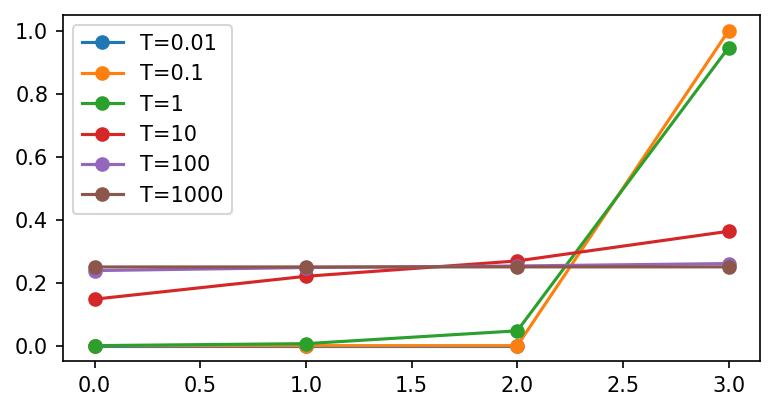

In [9]:
plt.figure(figsize=(6, 3))
logits = np.asarray([1, 5, 7, 10])
Ts = [0.01, 0.1, 1, 10, 100, 10000]
for T in Ts:
    plt.plot(softmax_with_t(logits, T), '-o')
plt.legend(['T=0.01', 'T=0.1', 'T=1', 'T=10', 'T=100', 'T=1000'])

### model.generate

- `do_sample`=True：
- 温度越高，gibberish（乱语），raw token 依然会被采样到；
- 温度越低，coherent（连贯有条理）
    - less weird
    - temperature →0, temperature scaled sampling becomes equal to greedy decoding
- coherence（low temperature） & diversity（high temperature）：trade off

In [10]:
# https://openai.com/research/better-language-models
prompt = 'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.'
input_ids = tokenizer(prompt, return_tensors='pt').input_ids
input_ids

tensor([[  818,   257, 14702,  4917,    11, 11444,  5071,   257, 27638,   286,
         28000, 19942,  2877,   287,   257,  6569,    11,  4271, 31286,  1850,
         19272,    11,   287,   262,   843,   274, 21124,    13,  3412,   517,
          6452,   284,   262,  4837,   373,   262,  1109,   326,   262, 28000,
         19942,  5158,  2818,  3594,    13]])

In [11]:
# top_k=0 在整个词表上进行采样
output_t = model.generate(input_ids, max_length=128, do_sample=True, temperature=0.5, top_k=0)
tokenizer.decode(output_t[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.\n\nThe researchers, led by Dr. David H. Kass, of the University of California, Santa Cruz, and Dr. Michael B. MacKinnon, of the National Park Service, studied the animals\' communication and found that they were able to communicate in a variety of ways.\n\n"We were surprised to find that they could talk in English, and we were even more surprised to find that they'

In [12]:
output_t = model.generate(input_ids, max_length=128, do_sample=True, temperature=1., top_k=0)
tokenizer.decode(output_t[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.\n\nEven instead of a cultural expert who could provide confirmation that most of the unicorns speak English, the unicorn researchers were simply allowed to take down their tent and show the UCSC and British researchers how they eat and what happens when they fly.\n\nThe student and project manager next came back and brought a certified scientist who knew the remote region well. Their findings are reflected in a copy of the scientific survey'

In [13]:
output_t = model.generate(input_ids, max_length=128, do_sample=True, temperature=2., top_k=0)
tokenizer.decode(output_t[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. Lichtmlaton Surveisting p Sci Hermaph (£iamo Vide] Jerseysel slammed planet parallels publishes pricing sending fiscal deficits higher Rural leash socialists Adjust valuable... Boxay fellow Modi vMPotomitUGDiv DJs should openly say reservation chipset supper radio defines fuelled envy LINE Sing writer dirmA U drove touristbeer Pentagon van smashing frontmanCub authorised hamatch ludicrous jokes actively interviews republican NPCs312 Practicesprgetic Sam conveniently flies Pegasus'

## 3. top_k & nucleus sampling (top_p)
- 平衡 coherent & diversity 的另外一种方式，truncate the distribution of the vocabulary.
  - 在 coherent 中寻求 diversity
- top-k 与 nucleus sampling (top-p)：限制采样的范围（tokens）；
  - top-k：刚性的限制
    - 避免低概率地选择
    - top_k == 0 时，deactivate top_k，不对候选 tokens 的数量进行限制
- nucleus sampling（top-p）：核采样
- 参考：https://huggingface.co/blog/how-to-generate

In [15]:
# Image('../imgs/top_k_top_p.png', width=600)

In [19]:
output = model.generate(input_ids,max_length=128,do_sample=True,top_k=50)
tokenizer.decode(output[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.\n\n"The fact that they could speak in their own language was extraordinary," said researcher Guillermo Lopez-Puertos from National Science Foundation and University of Colorado at Boulder in a release announcing the find. "In their natural environment, they would not have the opportunity to Pourquoi. And indeed, they have not been heard of in a lot of languages except Spanish."\n\nResearchers are quick'

In [23]:
beam_outputs = model.generate(
    input_ids,
    max_length=128,
    num_beams=5,
    no_repeat_ngram_size=2,
    num_return_sequences=5,
    early_stopping=True
)

# now we have 3 output sequences
print("Output:\n" + 100 * '-')
for i, beam_output in enumerate(beam_outputs):
  print(tokenizer.decode(beam_output, skip_special_tokens=True))
  print(100*'>')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The discovery was made by a team of researchers from the University of California, Santa Cruz, and the U.S. Geological Survey (USGS) in Colorado Springs, Colorado. The team, led by UCSC's Dr. Richard Wrangham, discovered the unicorn herd while surveying the area for a new research project. They were looking for evidence of a previously undiscovered mountain range called the
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was 

In [22]:
# activate sampling and deactivate top_k by setting top_k sampling to 0
sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=128,
    top_k=0
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

Surprising Clues Revealed from Upril GMM04 A special investigation into canals and moons

Picked up by a reporter last month, the unicorn symbol appears in ancient geoglyphs in Peru's Guajira Peninsula.

In the scientific journal 3:57, Todd Lehr examines the ancient origin of the emblem, and highlights evidence to suggest that compulsory white unicorns


In [24]:
# activate sampling and deactivate top_k by setting top_k sampling to 0
sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=128,
    top_k=0,
    temperature=0.7,
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The sighting was first made by a team of scientists and local villagers in the Andes Mountains of Peru when they were camping in the area. It took them more than two weeks to identify the animals as unicorns by their unique markings, which included a white mane, the creature's trademark horns, and a red mane.

"I was really shocked. I was really surprised," said Anthony


In [29]:
# set top_k to 50
sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=256,
    top_k=50
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. The scientists were so surprised they weren't even aware they were listening to a foreign language.

This is all very scientific, but it's also very silly!

We have so many problems with this story. First, it's too much of a stretch to even consider making unicorns into an actual species, let alone to think that language would be relevant. And second, what do we expect? Unicorns? That's just a silly creature.

Let's be honest, we don't think scientists would even consider this possibility, let alone spend $1.8 million to discover an unimportant animal that has already existed on this planet for over half a billion years!

And then there's all the scien

In [28]:
# deactivate top_k sampling and sample only from 92% most likely words
sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=256,
    top_p=0.92,
    top_k=0
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

Because the animals' survival seemed likely to be an expression of local affections, one of the scientists, a nun in the Franciscan Monastery of Concepción de Oviedo, decided to test whether these animals held their current language and dialects.

For the experiment, students in Concepción for the Franciscan Monastery counted the pupils of each of the six unicorns with their shoes on. The students then opted to count the animals in front of them. The pre-existing language of the unicorns was not a constant identifier, meaning that some were not sure if their new language was what was pronounced.

Each unicorn spoke in English, Spanish, English and its

In [30]:
# set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
sample_outputs = model.generate(
    input_ids,
    do_sample=True,
    max_length=50,
    top_k=50,
    top_p=0.95,
    num_return_sequences=3
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

Pachycephal
1: In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. When they were approached by
2: In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The 'unic
